In [1]:
import torch
from torch import nn

torch.__version__

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

 How to Prevent Overfitting

Ways to prevent overfitting include cross-validation, in which the data being used for training the model is chopped into folds or partitions and the model is run for each fold. Then, the overall error estimate is averaged. Other methods include ensembling: predictions are combined from at least two separate models, data augmentation, in which the available data set is made to look diverse, and data simplification, in which the model is streamlined to avoid overfitting. 

In [2]:
import torchvision
from torchvision.transforms import ToTensor

train_dataset = torchvision.datasets.MNIST(root='mnist_ds',
                                           train=True,
                                           download=True,
                                           transform=ToTensor(),
                                           target_transform=None,
                                           )

test_dataset = torchvision.datasets.MNIST(root='mnist_ds',
                                          train=False,
                                          download=True,
                                          transform=ToTensor(),
                                          target_transform=None,
                                          )

100%|██████████| 9912422/9912422 [00:00<00:00, 119008081.37it/s]


Extracting mnist_ds/MNIST/raw/train-images-idx3-ubyte.gz to mnist_ds/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 28428935.42it/s]


Extracting mnist_ds/MNIST/raw/train-labels-idx1-ubyte.gz to mnist_ds/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 37102023.57it/s]


Extracting mnist_ds/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist_ds/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 10811877.85it/s]


Extracting mnist_ds/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist_ds/MNIST/raw



In [3]:

class_name = train_dataset.classes
class_name

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

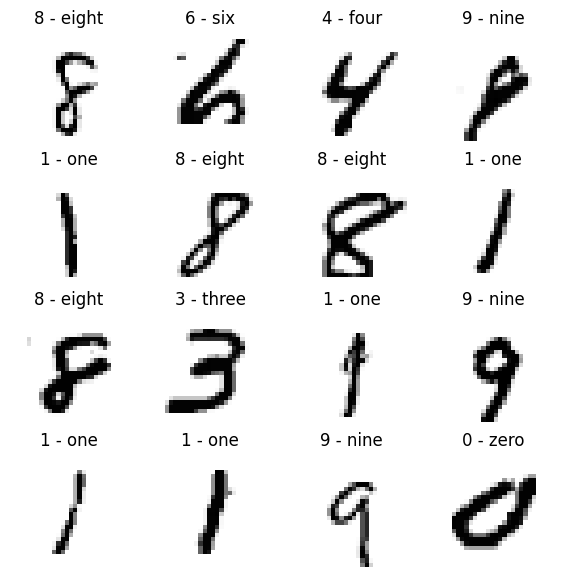

In [4]:
import matplotlib.pyplot as plt


fig = plt.figure(figsize=(7, 7))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):

  random_idx = torch.randint(0, len(train_dataset), size=[1]).item()

  image, label = train_dataset[random_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(image.squeeze(), cmap="Greys")
  plt.title(class_name[label])
  plt.axis(False)

In [5]:
from torch.utils.data import DataLoader

train_batch = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)

test_batch = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

In [6]:
train_features_batch, train_labels_batch = next(iter(train_batch))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

In [7]:
# Model

class TinyVGG(nn.Module):
  def __init__(self, in_shape, out_shape, hidden_units):
    super().__init__()
    self.block_1 = nn.Sequential(
        nn.Conv2d(in_channels=in_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)
    )

    self.block_2 = nn.Sequential(
        nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
        nn.ReLU(),
        nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*7*7,
                  out_features=out_shape),
    )

  def forward(self, x):
    x = self.block_1(x)
    x = self.block_2(x)
    x = self.classifier(x)
    return x


torch.manual_seed(42)
model_2 = TinyVGG(in_shape=1,
                  hidden_units=10,
                  out_shape=10).to(device)
model_2

TinyVGG(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [8]:
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  # Note: you need the "raw" GitHub URL for this to work
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

# Import accuracy metric
from helper_functions import accuracy_fn # Note: could also use torchmetrics.Accuracy(task = 'multiclass', num_classes=len(class_names)).to(device)


In [9]:
from timeit import default_timer as timer 


def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format). 
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time


In [10]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params=model_2.parameters(),
                            lr=0.01)

In [11]:
from tqdm.auto import tqdm
from timeit import default_timer as timer 

# Set the seed and start the timer
torch.manual_seed(42)
train_time_start_on_cpu = timer()

epochs = 4

for epoch in range(epochs):
  train_loss = 0

  for batch, (X, y) in enumerate(train_batch):
    model_2.train()

    X, y = X.to(device), y.to(device)

    y_logits = model_2(X)

    loss = loss_fn(y_logits, y)
    train_loss += loss

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch % 400 == 0:
      print(f'Now is {batch * len(X)} / {len(train_batch.dataset)} samples')

  train_loss /= len(train_batch)

  ### Testing
  test_loss, test_acc = 0, 0
  model_2.eval()
  with torch.inference_mode():
    for X, y in test_batch:
      X, y = X.to(device), y.to(device)

      test_pred = model_2(X)

      test_loss += loss_fn(test_pred, y)
      test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))

      test_loss /= len(test_batch)
      test_acc /= len(test_batch)

  print(f'\nTRain loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n')    

train_time_end_on_cpu = timer()

total_train_time_model_2 = print_train_time(start=train_time_start_on_cpu, 
                                           end=train_time_end_on_cpu,
                                           device=str(next(model_2.parameters()).device))


Now is 0 / 60000 samples
Now is 12800 / 60000 samples
Now is 25600 / 60000 samples
Now is 38400 / 60000 samples
Now is 51200 / 60000 samples

TRain loss: 1.10306 | Test loss: 0.00112, Test acc: 0.26%

Now is 0 / 60000 samples
Now is 12800 / 60000 samples
Now is 25600 / 60000 samples
Now is 38400 / 60000 samples
Now is 51200 / 60000 samples

TRain loss: 0.15943 | Test loss: 0.00010, Test acc: 0.32%

Now is 0 / 60000 samples
Now is 12800 / 60000 samples
Now is 25600 / 60000 samples
Now is 38400 / 60000 samples
Now is 51200 / 60000 samples

TRain loss: 0.10446 | Test loss: 0.00002, Test acc: 0.32%

Now is 0 / 60000 samples
Now is 12800 / 60000 samples
Now is 25600 / 60000 samples
Now is 38400 / 60000 samples
Now is 51200 / 60000 samples

TRain loss: 0.08579 | Test loss: 0.00001, Test acc: 0.32%

Train time on cpu: 231.504 seconds


In [12]:
def make_predictions(model: torch.nn.Module, data: list, device: torch.device = device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # Prepare sample
            sample = torch.unsqueeze(sample, dim=0).to(device) # Add an extra dimension and send sample to device

            # Forward pass (model outputs raw logit)
            pred_logit = model(sample)

            # Get prediction probability (logit -> prediction probability)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)

            # Get pred_prob off GPU for further calculations
            pred_probs.append(pred_prob.cpu())
            
    # Stack the pred_probs to turn list into a tensor
    return torch.stack(pred_probs)


In [13]:
import random

# random.seed(42)
test_samples = []
test_labels = []

for sample, label in random.sample(list(test_dataset), k=9):
  test_samples.append(sample)
  test_labels.append(label)

# View the first test sample shape and label
print(f'Test sample image shape: {test_samples[0].shape}\nTest sample label: {test_labels} ({class_name[test_labels[0]]})')
# class_name
# test_labels[0][0]

Test sample image shape: torch.Size([1, 28, 28])
Test sample label: [1, 3, 2, 7, 5, 6, 7, 4, 0] (1 - one)


In [14]:

# Make predictions on test samples with model 2
pred_probs= make_predictions(model=model_2, 
                             data=test_samples)

# View first two prediction probabilities list
pred_probs[:2]


tensor([[5.5900e-07, 9.9207e-01, 2.6670e-04, 4.6270e-06, 7.8323e-04, 1.6114e-07,
         9.2644e-05, 6.4588e-04, 6.1274e-03, 7.7507e-06],
        [2.0344e-08, 2.1509e-06, 4.4813e-08, 5.0666e-01, 1.4551e-07, 4.9307e-01,
         9.5488e-08, 2.6622e-05, 2.4166e-04, 4.1633e-06]])

In [15]:

# Turn the prediction probabilities into prediction labels by taking the argmax()
pred_classes = pred_probs.argmax(dim=1)
pred_classes


tensor([1, 3, 2, 7, 5, 6, 7, 4, 0])

In [16]:
# Are our predictions in the same form as our test labels? 
test_labels, pred_classes


([1, 3, 2, 7, 5, 6, 7, 4, 0], tensor([1, 3, 2, 7, 5, 6, 7, 4, 0]))

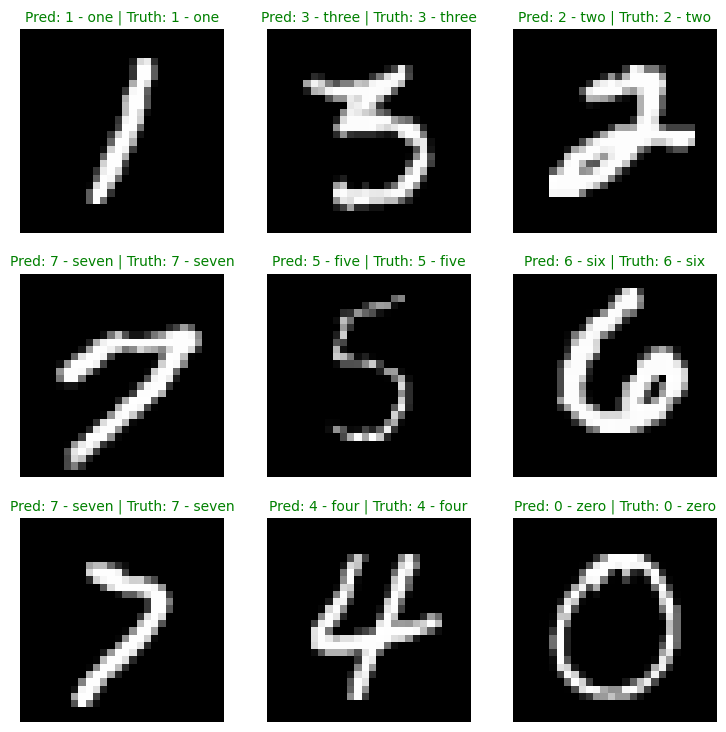

In [17]:
# Pot predictions
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3

for i, sample in enumerate(test_samples):
  # Create a subplot
  plt.subplot(nrows, ncols, i+1)

  # Plot the target image
  plt.imshow(sample.squeeze(), cmap='gray')

  # Find the prediction label (in text form, e.g. "Two")
  pred_label = class_name[pred_classes[i]]

  # Get the truth label (in text form e.g. "T-shirt")
  truth_label = class_name[test_labels[i]]

  # Create the title text of the plot
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"

  # Check for equality and chenge title colour accordingly
  if pred_label == truth_label:
    plt.title(title_text, fontsize=10, c="g") # green text if correct
  else:
    plt.title(title_text, fontsize=10, c="r") # red text if wrong
  
  plt.axis(False);



In [18]:
from tqdm.auto import tqdm

# Make predictions with trained model
y_preds = []
model_2.eval()

with torch.inference_mode():
  for X, y in tqdm(test_batch, desc="Making predictions"):
    # Send data and targets to target device
    X, y = X.to(device), y.to(device)

    # Forward pass
    y_logit = model_2(X)

    # Turn predictions from logits -> prediction probabilities -> prediction labels
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)

    # Put predictions on CPU for evaluation
    y_preds.append(y_pred.cpu())

# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)

Making predictions:   0%|          | 0/313 [00:00<?, ?it/s]

In [19]:
# install packages
try:
  import torchmetrics, mlxtend
  print(f'mlxtend version: {mlxtend.__version__}')
  assert int(mlxtend.__version__.split('.')[1]) >= 19, "mlxtend version should be 0.19.0 or higher"
except:
  !pip install torchmetrics -U mlxtend
  import torchmetrics, mlxtend
  print(f"mlxtend version: {mlxtend.__version__}")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 59.8 MB/s eta 0:00:00
  Attempting uninstall: mlxtend
    Found existing installation: mlxtend 0.14.0
    Uninstalling mlxtend-0.14.0:
      Successfully uninstalled mlxtend-0.14.0
mlxtend version: 0.22.0


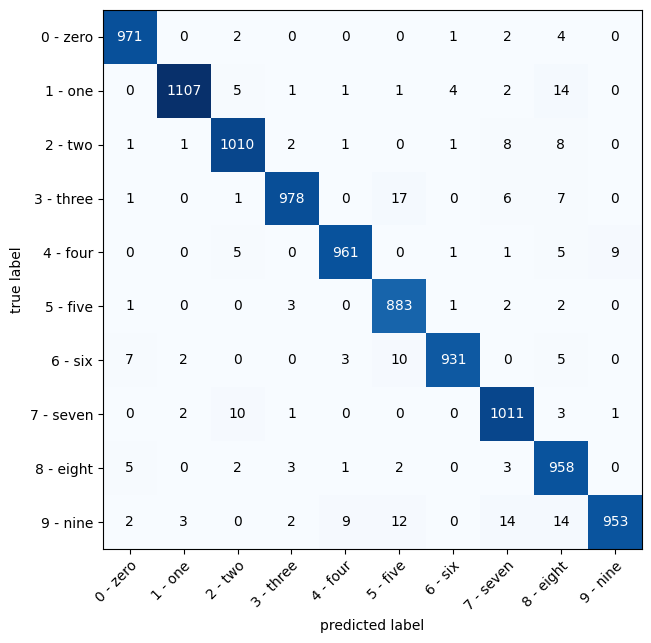

In [20]:
import mlxtend
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_name), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=test_dataset.targets)

# Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with numpy
    class_names=class_name,
    figsize=(10, 7)
)


12. Create a random tensor of shape [1, 3, 64, 64] and pass it through a nn.Conv2d() layer with various hyperparameter settings (these can be any settings you choose), what do you notice if the kernel_size parameter goes up and down?

In [24]:
rand_tens_2d = torch.rand([1, 3, 64, 64])

rand_tens_2d

tensor([[[[0.6429, 0.7708, 0.5860,  ..., 0.6084, 0.4709, 0.7639],
          [0.9142, 0.7464, 0.0988,  ..., 0.8037, 0.2194, 0.8018],
          [0.8832, 0.6134, 0.8766,  ..., 0.5332, 0.5766, 0.2763],
          ...,
          [0.0300, 0.9399, 0.0341,  ..., 0.3768, 0.0712, 0.4601],
          [0.8781, 0.7127, 0.3247,  ..., 0.2819, 0.9821, 0.5455],
          [0.0289, 0.8532, 0.5064,  ..., 0.4871, 0.6780, 0.9875]],

         [[0.3881, 0.3824, 0.9321,  ..., 0.7903, 0.3832, 0.0856],
          [0.3908, 0.2665, 0.0283,  ..., 0.6619, 0.5040, 0.8543],
          [0.1640, 0.4911, 0.0854,  ..., 0.9003, 0.5369, 0.6411],
          ...,
          [0.1244, 0.9454, 0.7007,  ..., 0.3224, 0.8962, 0.2316],
          [0.8152, 0.7513, 0.2620,  ..., 0.8674, 0.4415, 0.4627],
          [0.0115, 0.2047, 0.7969,  ..., 0.5134, 0.4093, 0.1899]],

         [[0.0154, 0.2712, 0.9032,  ..., 0.4169, 0.5814, 0.8398],
          [0.3650, 0.4380, 0.6917,  ..., 0.8587, 0.2894, 0.6609],
          [0.7722, 0.9334, 0.8887,  ..., 0

In [70]:
layer_2d = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=1)

layer_2d

Conv2d(3, 10, kernel_size=(1, 1), stride=(1, 1))

In [71]:
through_2d_layer = layer_2d(rand_tens_2d)

through_2d_layer

tensor([[[[ 0.9070,  0.8421,  0.4894,  ...,  0.7306,  0.5340,  0.5196],
          [ 0.8682,  0.7331,  0.2518,  ...,  0.5926,  0.5672,  0.7123],
          [ 0.6225,  0.4402,  0.5519,  ...,  0.6254,  0.5004,  0.7539],
          ...,
          [ 0.5595,  0.6858,  0.5404,  ...,  0.7203,  0.2860,  0.4777],
          [ 0.6063,  0.5843,  0.7067,  ...,  0.5133,  1.0840,  0.5980],
          [ 0.2714,  0.6063,  0.7175,  ...,  0.6267,  0.5267,  0.9304]],

         [[ 0.1444,  0.1934,  0.0434,  ...,  0.0756,  0.0700,  0.2216],
          [ 0.2486,  0.1964, -0.0353,  ...,  0.1649, -0.0424,  0.1422],
          [ 0.2601,  0.1094,  0.2661,  ...,  0.0300,  0.0906, -0.0337],
          ...,
          [-0.0676,  0.1835, -0.1401,  ...,  0.0454, -0.1564,  0.0840],
          [ 0.1745,  0.1179,  0.0326,  ..., -0.0658,  0.2733,  0.0902],
          [-0.0599,  0.2429,  0.0349,  ...,  0.0617,  0.1469,  0.3042]],

         [[ 0.1981, -0.0046, -0.1700,  ...,  0.0639, -0.0365, -0.3704],
          [-0.1222, -0.1067,  